# Encoding scratchpad

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [2]:
## Prep paths ##

subject = 'BJH025'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [3]:
## Load Neural Data

roi_pres_TFR = mne.time_frequency.read_tfrs(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/trial_onset/hc-itibaseline-tfr.h5")
roi_pres_TFR = roi_pres_TFR[0]

Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/trial_onset/hc-itibaseline-tfr.h5 ...
Not setting metadata


In [4]:
def tidy_end_of_trials(df):
    
    if df['UserLocation'].iloc[0] > 95:
        # Find the index where 'UserLocation' first hits or exceeds 170
        hit_170_index = df[df['UserLocation'] > 170].index.min()

        # If there is no such index (i.e., 'UserLocation' never hits or exceeds 170), 
        # return the DataFrame as it is
        if pd.isna(hit_170_index):
            return df
        else:
            # If there is such an index, return only the part of the DataFrame before it
            return df.loc[:hit_170_index]
    else:
        # Find the index where 'UserLocation' first hits or is below 10
        hit_10_index = df[df['UserLocation'] < 10].index.min()

        # If there is no such index (i.e., 'UserLocation' never hits or exceeds 170), 
        # return the DataFrame as it is
        if pd.isna(hit_10_index):
            return df
        else:
            # If there is such an index, return only the part of the DataFrame before it
            return df.loc[:hit_10_index]

        

In [5]:
## Prep Behavioral Data ##

# Load Data #
trial_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_raw_encoding_behave.csv")

# Fix incorrect trial labeling
trial_data = trial_data[trial_data['Trial'] != 7] # Equivalent to filter()
trial_data['Trial'] = np.where(trial_data['Trial'] < 7, trial_data['Trial'], trial_data['Trial'] - 1) # Equivalent to if_else()

# Remove first trial because there was not enough
trial_data = trial_data[trial_data['Trial'] != 0]
trial_data['Trial'] = trial_data['Trial'] - 1

# Clean Up Trial/Trial Type and exclude bad epochs #
trial_data['Trial'] = trial_data['Trial'] - 1
trial_data['TrialType'] = trial_data.groupby('Trial')['TrialType'].transform(lambda x: x.mode().iloc[0])
trial_data = trial_data[trial_data['Trial'] >=0]
trial_data = trial_data.drop(trial_data.columns[0], axis=1)
trial_data = trial_data[trial_data['Trial_on_off'] != 0]

# Exclude end of trial location jumps
trial_data = trial_data.groupby('Trial').apply(tidy_end_of_trials).reset_index(drop=True)

# Create trial time variable
trial_data = trial_data.rename(columns={'Time': 'sample'})
trial_data['Time'] = trial_data['sample'] / 2000
trial_data['Time'] = trial_data.groupby('Trial')['Time'].transform(lambda x: x - x.iloc[0]).round(2)

In [6]:
# load old pres data to help add metadata
trial_onset_epochs = mne.read_epochs(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/{subject}_bp_clean_pres-locked_ieeg.fif")

bad_epochs = []
for idx, annot in enumerate(trial_onset_epochs.get_annotations_per_epoch()):
    if annot:
        for bad_annot in list(set(annot)):
            trial_end = 1 + trial_data[trial_data['Trial'] == idx]['Time'].max() # note that idx and trial are the same because we have not excluded trials (besides the ones needed to align to neural data)
            trial_start = -1
            bad_start = bad_annot[0]
            bad_end = bad_start + bad_annot[1]
            if trial_start < bad_end and trial_end > bad_start: # if they overlap
                bad_epochs.append(idx)
good_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if i not in bad_epochs]
bad_epochs

Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_clean_pres-locked_ieeg.fif ...


/tmp/ipykernel_19003/2819449321.py:2: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_clean_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  trial_onset_epochs = mne.read_epochs(f"/home/brooke/pacman/preprocessing/{subject}/ieeg/{subject}_bp_clean_pres-locked_ieeg.fif")


    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_clean_pres-locked_ieeg-1.fif ...
    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/BJH025/ieeg/BJH025_bp_clean_pres-locked_ieeg-2.fif ...
    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Not setting metadata
237 matching events found
No baseline correction applied
0 projection items activated


[1,
 3,
 4,
 5,
 8,
 8,
 17,
 33,
 42,
 56,
 72,
 73,
 90,
 92,
 93,
 99,
 107,
 136,
 160,
 163,
 175,
 204,
 205,
 211,
 217,
 225,
 234]

In [7]:
len(trial_data['Trial'].unique())

237

In [8]:
len(good_epochs)

211

In [9]:
## Exclude bad Trials
trial_data = trial_data[trial_data['Trial'].isin(good_epochs)]

trial_data.to_csv(f"{preproc_data_dir}/linear_encoding/cleaned_trial_behavior.csv")

In [10]:
def plot_distance_vs_time(df):
    # Get unique trials
    trials = df['Trial'].unique()

    # Create a subplot for each trial
    fig, axs = plt.subplots(len(trials), 1, figsize=(10, 6*len(trials)))

    for i, trial in enumerate(trials):
        trial_data = df[df['Trial'] == trial]
        axs[i].plot(trial_data['Time'], trial_data['distance_to_ghost'], label=f'Trial {trial}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Distance to Ghost')
        axs[i].legend()
        axs[i].set_title(f'Distance to Ghost as a function of Time for Trial {trial}')
    
    plt.tight_layout()
    plt.show()


# Call the function with your DataFrame
# plot_distance_vs_time(trial_data[(trial_data['Trial'] > 119) & (trial_data['Trial'] < 240)])

## Prep Neural Data

In [11]:
## Dictionary of electrode locations ##

# Dictionary mapping ROI to elecs
ROIs = {
    'hc'     :['HL1', 'HL2', 'HR1', 'HR2', 'I1', 'I2', 'I3', 'I4'],
    'ofc'    :['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'B1', 'B2', 'B3'],
    'amyg'   :['C1', 'C2', 'GL1', 'GL2', 'GL3', 'GL4', 'GL5', 'GR1', 'GR2', 'GR3', 'GR4', 'GR5'],
    'cing'   :['B10'],
    'insula' :['C4', 'C5', 'C6', 'C7', 'C8', 'D1', 'D2', 'D3', 'D4'],
    'dlpfc'  :['C13', 'C14', 'C15', 'C16'],
    'ec'     :['J1', 'J2', 'J3']
}

## prep lists

# primary ROI
hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = [] 
amyg_indices = []
cing_list = []
cing_names = [] 
cing_indices = []

# control ROI
insula_list = []
insula_names = []  
insula_indices = []
dlpfc_list = []
dlpfc_names = []  
dlpfc_indices = []
ec_list = []
ec_names = []  
ec_indices = []

# exclude bad ROI from list (because all the bad channels are in front)
pairs_long_name = [ch.split('-') for ch in roi_pres_TFR.info['ch_names']]
bidx = 0
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

# sort ROI into lists
for ix in range(0, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(roi_pres_TFR.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(roi_pres_TFR.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(roi_pres_TFR.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
        amyg_indices.append(ix)
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(roi_pres_TFR.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        cing_indices.append(ix)
        
    # control roi
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(roi_pres_TFR.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
        insula_indices.append(ix)
    if pairs_name[ix][0] in ROIs['dlpfc'] or pairs_name[ix][1] in ROIs['dlpfc']:
        dlpfc_list.append(roi_pres_TFR.info['ch_names'][ix + bidx])       
        dlpfc_names.append(pairs_name[ix])
        dlpfc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ec'] or pairs_name[ix][1] in ROIs['ec']:
        ec_list.append(roi_pres_TFR.info['ch_names'][ix + bidx])       
        ec_names.append(pairs_name[ix])
        ec_indices.append(ix)        
        

In [12]:
## Prep neural data ##

# extra theta #
theta_data = roi_pres_TFR.copy().crop(-1, 9, 3, 8)

# average across trials
theta_average = theta_data.copy()._data.mean(axis = 2).mean(axis = 0)

# create a time mask
mask_time_ecog = mne.utils._time_mask(roi_pres_TFR.times, 0, 9)

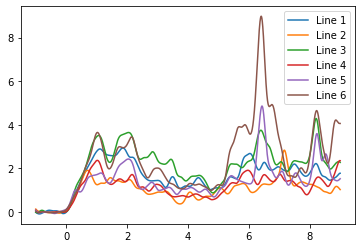

In [13]:
# Create a new figure
plt.figure()

# Plot the first line
plt.plot(theta_data.times, theta_average[0, :], label='Line 1')

# Plot the second line
plt.plot(theta_data.times, theta_average[1, :], label='Line 2')

# Plot the second line
plt.plot(theta_data.times, theta_average[2, :], label='Line 3')

# Plot the second line
plt.plot(theta_data.times, theta_average[3, :], label='Line 4')

# Plot the second line
plt.plot(theta_data.times, theta_average[4, :], label='Line 5')

# Plot the second line
plt.plot(theta_data.times, theta_average[5, :], label='Line 6')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Based on the above plot we will use 'I1-I2'. Technically I chose when the graph was limited to 5 seconds

In [14]:
sample_elec_data = theta_data.copy().pick_channels(['I1-I2']).crop(0, 8.7)

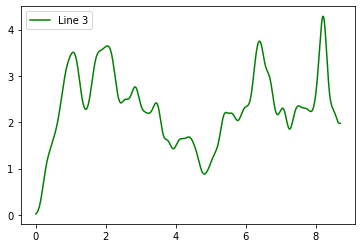

In [15]:
plt.plot(sample_elec_data.times, sample_elec_data._data.mean(axis = 0).mean(axis = 0).mean(axis = 0), label='Line 3', color = 'green')
plt.legend()

In [61]:
# decimate
sample_elec_data.decimate(10)

<EpochsTFR | time : [0.000000, 8.700000], freq : [3.131975, 7.611227], epochs : 211, channels : 1, ~21.0 MB>

In [62]:
sample_elec_data.save(f"{preproc_data_dir}/linear_encoding/theta_I1-I2_ecog-epo.fif", overwrite = True)

In [16]:
sample_elec_data._data.shape

(211, 1, 15, 8701)

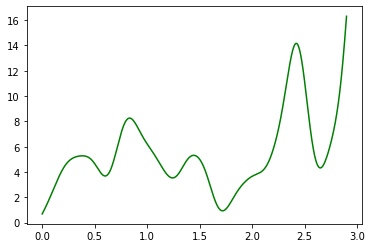

In [26]:
plt.plot(sample_elec_data.times[0:2900], sample_elec_data._data[210, :, :, 0:2900].mean(axis = 0).mean(axis = 0), label='Line 3', color = 'green')
